### This trains and tests various models on data obtained from the school's admissions office regarding applicants, to predict which of those applicants will subsequently enroll, and which will withdraw their application.

In [1]:
import pandas as pd, numpy as np, os
from sklearn import metrics
from matplotlib import pyplot as plt
stdata=pd.read_excel('./applicants_since_2000.xlsx')

After some EDA, a number of variables are in need of wrangling- State applied, and Nation applied ought to be combined

In [2]:
stdata.loc[pd.notnull(stdata['state_applied']) & pd.isnull(stdata['nation_applied']), 'nation_applied']="USA"
stdata['hs_location']=np.where(stdata['hs_country'].notnull(), stdata['hs_country'], stdata['hs_state'])
stdata=stdata.drop(columns=['hs_country','hs_city', 'hs_state','state_applied','student'], axis=1)

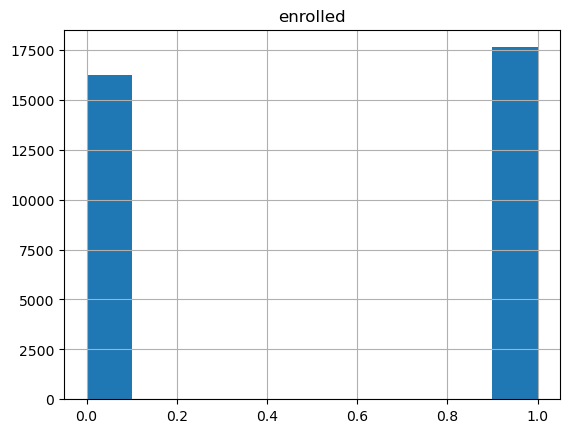

In [3]:
stdata.hist('enrolled')
plt.show()

In [4]:
stdata.hs_location.value_counts()

NY           11966
NJ            6314
CA            2130
FL            1770
MD            1479
             ...  
LA               1
CHINA            1
JAMAICA          1
NICARAGUA        1
AUSTRALIA        1
Name: hs_location, Length: 79, dtype: int64

In [5]:
hsloc=stdata.hs_location.value_counts()
hsrareloc=hsloc[hsloc.values<100].index.values
stdata['hs_location']=np.where(stdata['hs_location'].isin(hsrareloc),"UNUSUAL",stdata['hs_location'])

In [6]:
stdata['hs_location'].value_counts()

NY                11966
NJ                 6314
CA                 2130
FL                 1770
MD                 1479
IL                 1460
CANADA              817
UNUSUAL             764
PA                  714
OH                  679
Unknown Nation      597
MA                  555
TX                  352
MI                  310
GA                  276
TN                  206
MO                  206
CT                  177
WA                  175
PANAMA              159
Name: hs_location, dtype: int64

In [7]:
natnapp=stdata.nation_applied.value_counts()
rareapp=natnapp[natnapp.values<15].index.values
stdata['nation_applied']=np.where(stdata['nation_applied'].isin(rareapp),"Exotic",stdata['nation_applied'])
stdata.nation_applied.value_counts()

USA                   30761
CANADA                  903
CHINA                   439
ISRAEL                  331
FRANCE                  240
Exotic                  203
PANAMA                  200
MOROCCO                 156
UNITED KINGDOM           62
VENEZUELA                56
SOUTH AFRICA             56
BRAZIL                   36
ITALY                    30
BELGIUM                  29
CHILE                    29
ARGENTINA                28
RUSSIAN FEDERATION       23
MEXICO                   23
COLOMBIA                 20
GERMANY                  19
SWITZERLAND              15
UKRAINE                  15
Name: nation_applied, dtype: int64

In [8]:
majlist=stdata.major_applied.value_counts()
uncmajor=majlist[majlist.values<50].index.values
stdata['major_applied']=np.where(stdata['major_applied'].isin(uncmajor),"MISC",stdata['major_applied'])
stdata.major_applied.value_counts()

UND     8602
0000    5840
BUS     4389
BIO     3096
PSY     2475
PRE      907
COM      885
POL      775
MAT      672
ACC      639
EDU      627
ENG      609
SHA      461
HIS      438
ECO      434
MISC     420
JST      384
CHE      339
PRH      223
PHY      184
FIN      181
LAW      141
SPAU     141
SOC      140
PHI      136
JED      103
MED      101
SCW       90
ART       87
MAR       85
BC        79
BANA      79
MUS       75
SENT      56
Name: major_applied, dtype: int64

In [9]:
stdata.describe()

,enrolled,aidpct,act_composite,sat_total
count,33893.000000,33893.000000,8268.000000,22110.000000
mean,0.520373,39.458472,26.165215,1210.719493
std,0.499592,42.162733,4.412151,170.309025
min,0.000000,0.000000,7.000000,420.000000
25%,0.000000,0.000000,23.000000,1100.000000
50%,1.000000,32.000000,26.000000,1210.000000
75%,1.000000,69.000000,30.000000,1340.000000
max,1.000000,1000.000000,36.000000,1600.000000


In [10]:
stdata['aidpct']=np.where(stdata['aidpct']>120, 120, stdata['aidpct'])
stdata.describe()

,enrolled,aidpct,act_composite,sat_total
count,33893.000000,33893.000000,8268.000000,22110.000000
mean,0.520373,38.193403,26.165215,1210.719493
std,0.499592,38.338292,4.412151,170.309025
min,0.000000,0.000000,7.000000,420.000000
25%,0.000000,0.000000,23.000000,1100.000000
50%,1.000000,32.000000,26.000000,1210.000000
75%,1.000000,69.000000,30.000000,1340.000000
max,1.000000,120.000000,36.000000,1600.000000


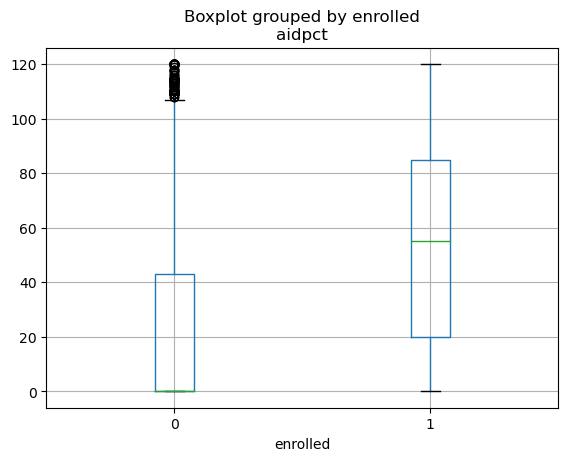

In [11]:
stdata.boxplot('aidpct',by='enrolled')
plt.show()

In [12]:
stdata['aidbin']=pd.cut(stdata['aidpct'],[0,20,50,75,100,126], include_lowest=True)
stdata.aidbin.value_counts()

(-0.001, 20.0]    15063
(20.0, 50.0]       6260
(50.0, 75.0]       5735
(75.0, 100.0]      4535
(100.0, 126.0]     2300
Name: aidbin, dtype: int64

The SAT and ACT scores measure the same thing, but on different scales, so we convert the ACT into SAT using the tables provided by CollegeBoard.

In [13]:
actsat={36:1590,35:1540,34:1500,33:1460,32:1430,31:1400,30:1370,29:1340,28:1310,27:1280,
        26:1240,25:1210,24:1180,23:1140,22:1110,21:1080,20:1040,19:1010,18:970,17:930,16:890,15:850,
        14:800,13:760,12:710,11:670,10:630,9:590}

In [14]:
stdata=stdata.drop(columns='aidpct')

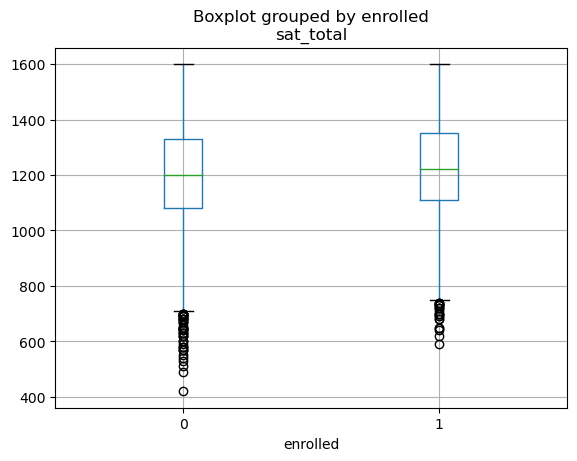

In [15]:
stdata.boxplot('sat_total', by='enrolled')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
dftrain, dftest, targettrain, targettest = train_test_split(stdata.drop(columns='enrolled'),stdata['enrolled'], test_size=.2, random_state=2)


In [17]:
cities=dftrain.city_applied.value_counts()

In [18]:
bigcities=cities[cities.values>100].index.values
dftrain['big_city']=dftrain['city_applied'].isin(bigcities).astype(int)
dftrain=dftrain.drop(columns='city_applied', axis=1)

In [19]:
dftrain.loc[(dftrain['sat_total'] <500),'sat_total' ]=np.nan
dftrain.loc[(dftrain['act_composite'] <9),'act_composite' ]=np.nan
dftrain['sat_act']=np.where(dftrain.act_composite.notnull(), dftrain['act_composite'].replace(actsat), dftrain.sat_total)
satmean=dftrain.sat_act.mean()
dftrain['sat_act']=dftrain['sat_act'].fillna(int(satmean))
dftrain=dftrain.drop(columns=['act_composite','sat_total'], axis=1)
dftrain['hs_gpa']=pd.to_numeric(dftrain.hs_gpa, errors='coerce')

In [20]:
dftrain['sat_act']=(dftrain['sat_act']/5).round().astype(int)*5

In [21]:
dftrain.loc[(dftrain['hs_gpa'] > 120)|(dftrain['hs_gpa'] < 60) | (pd.isnull(dftrain['hs_gpa'])),'hs_gpa' ]=np.nan

In [22]:
hsgpamedian=dftrain.hs_gpa.median()
dftrain['hs_gpa']=dftrain['hs_gpa'].fillna(hsgpamedian)

In [23]:
dftrain['hs_gpa']=dftrain['hs_gpa'].round(2)

In [24]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27114 entries, 32189 to 23720
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   college         27114 non-null  object  
 1   major_applied   27114 non-null  object  
 2   gender          27114 non-null  object  
 3   nation_applied  26937 non-null  object  
 4   hs_gpa          27114 non-null  float64 
 5   ethnicity       27114 non-null  object  
 6   hs_location     24854 non-null  object  
 7   aidbin          27114 non-null  category
 8   big_city        27114 non-null  int32   
 9   sat_act         27114 non-null  int32   
dtypes: category(1), float64(1), int32(2), object(6)
memory usage: 1.9+ MB


<Figure size 640x480 with 0 Axes>

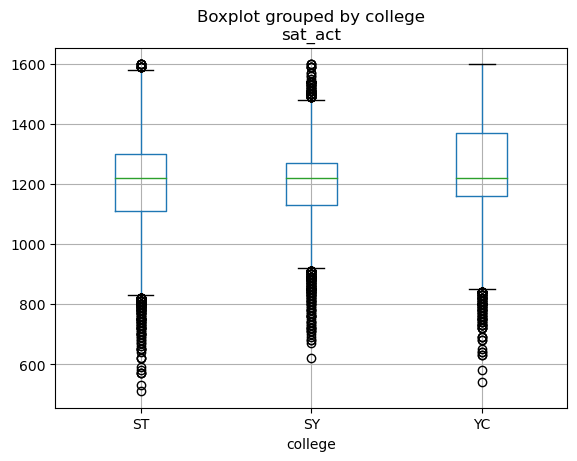

In [25]:
plt.cla()
plt.clf()
dftrain.boxplot('sat_act', by='college')
plt.show()

In [26]:
dftrain2=pd.get_dummies(dftrain)
dftrain2.shape # Just checking

(27114, 98)

In [27]:
dftrain2.hs_gpa.describe()

count    27114.000000
mean        89.407820
std          5.211251
min         60.030000
25%         86.430000
50%         90.000000
75%         93.000000
max        109.000000
Name: hs_gpa, dtype: float64

In [28]:
dftrain2.hs_gpa.head(100)

32189    90.97
25031    90.00
3128     90.56
6266     85.50
25566    96.00
         ...  
26287    86.00
4171     98.10
2868     87.68
11913    88.00
27321    93.10
Name: hs_gpa, Length: 100, dtype: float64

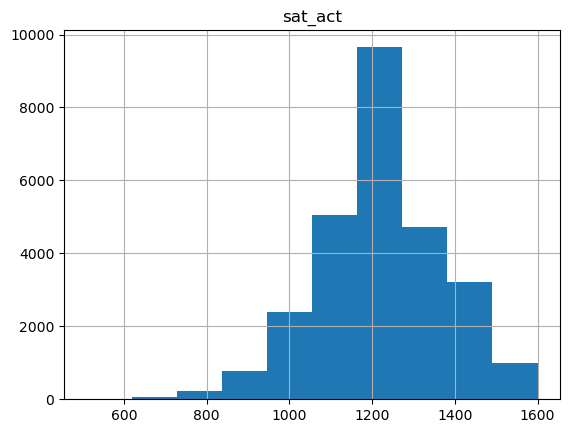

In [29]:
#dftrain2.hist(column='hs_gpa')
dftrain2.hist('sat_act')
plt.show()

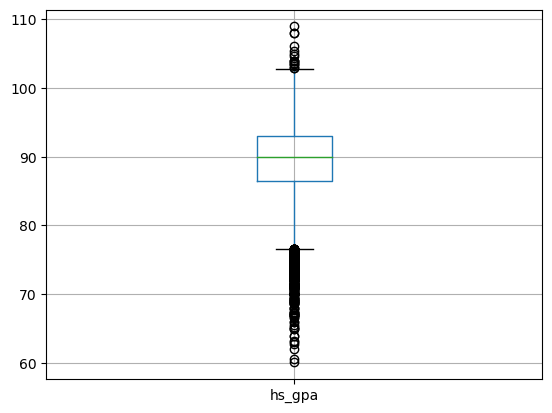

In [30]:
dftrain2.boxplot('hs_gpa')
plt.show()

In [31]:
# Checking for nulls
for x in dftrain2.columns :
    if dftrain2[x].isnull().sum()!=0:
        print (x, dftrain2[x].isnull().sum())

In [32]:
# Eliminating the duplicates gender field:
dftrain2=dftrain2.drop(columns='gender_F')

In [33]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [34]:
# Only the HS GPA and SAT/ACT fields need scaling
st=MinMaxScaler()
st2=MinMaxScaler() # for later
stf=st.fit(dftrain2[['hs_gpa','sat_act']])
st2f=st2.fit(dftrain2[['hs_gpa','sat_act']]) # for later

In [35]:
dttwocols=st.fit_transform(dftrain2[['hs_gpa','sat_act']])
dftrain2['hs_gpa']=dttwocols[:,0]
dftrain2['sat_act']=dttwocols[:,1]

In [36]:
dt=dftrain2
dt = dt.reindex(sorted(dt.columns), axis=1)

Now that we alphabetized the columns (necessary for later), we can train our model!

Let's start with a KNN classifier with 2 neighbors:

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
kn=KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knmodel=kn.fit(dt,targettrain)
knpredict=kn.predict(dt)

In [38]:
metrics.confusion_matrix(targettrain, knpredict)

array([[13005,     6],
       [ 5191,  8912]], dtype=int64)

In [39]:
kn.score(dt,targettrain)

0.8083278011359445

In [40]:
print(metrics.classification_report(targettrain,knpredict))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83     13011
           1       1.00      0.63      0.77     14103

    accuracy                           0.81     27114
   macro avg       0.86      0.82      0.80     27114
weighted avg       0.86      0.81      0.80     27114



This might be perfect for our needs- since it will advise the admissions office of applicants who we expect will not come, and of those we are almost definitely correct.

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
kn2=KNeighborsClassifier()
pipe=Pipeline([("knn", kn2)])
search_space = [{"knn__n_neighbors": [1, 3, 5, 7, 9]}]
bkn = GridSearchCV(pipe, search_space, cv=5, n_jobs=-1, verbose=0).fit(dt, targettrain)

In [42]:
bkn.best_estimator_.get_params()["knn__n_neighbors"]

9

In [43]:
kn3=KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
pipe2=Pipeline([("knn", kn3)])
model2=pipe2.fit(dt, targettrain)
print(model2.score(dt,targettrain))
modelpredict=pipe2.predict(dt)
print(metrics.confusion_matrix(targettrain,modelpredict))


0.742937228000295
[[ 9629  3382]
 [ 3588 10515]]


Now the big test! the test data!

In [44]:
dftest['big_city']=dftest['city_applied'].isin(bigcities).astype(int)
dftest=dftest.drop(columns='city_applied', axis=1)
dftest['sat_act']=np.where(dftest.act_composite.notnull(), dftest['act_composite'].replace(actsat), dftest.sat_total)
dftest['sat_act']=dftest['sat_act'].fillna(satmean)
dftest=dftest.drop(columns=['act_composite','sat_total'], axis=1)
dftest['hs_gpa']=pd.to_numeric(dftest.hs_gpa, errors='coerce')
dftest['sat_act']=(dftest['sat_act']/5).round().astype(int)*5
dftest.loc[(dftest['hs_gpa'] > 120) | (dftest['hs_gpa'] < 60) | (pd.isnull(dftest['hs_gpa'])),'hs_gpa' ]=np.nan
dftest['hs_gpa']=dftest['hs_gpa'].fillna(hsgpamedian)
dftest['hs_gpa']=dftest['hs_gpa'].round(2)

print(dftest.shape)
dftest.head()



(6779, 10)


,college,major_applied,gender,nation_applied,hs_gpa,ethnicity,hs_location,aidbin,big_city,sat_act
11157,YC,PSY,M,USA,92.00,8. White,MD,"(-0.001, 20.0]",1,1350
19246,YC,UND,M,USA,75.89,8. White,NJ,"(75.0, 100.0]",0,1010
23485,YC,0000,M,USA,98.06,8. White,NJ,"(75.0, 100.0]",0,1410
8515,YC,UND,M,FRANCE,90.00,8. White,NaN,"(50.0, 75.0]",0,1220
20911,YC,0000,M,USA,91.66,8. White,NY,"(20.0, 50.0]",1,1140


In [45]:
dftest2=pd.get_dummies(dftest)
dftest2=dftest2.drop(columns='gender_F')

In [46]:
dftest2.shape

(6779, 96)

In [47]:
dtst2=st2.transform(dftest2[['hs_gpa','sat_act']])

In [48]:
dftest2['hs_gpa']=dtst2[:,0]
dftest2['sat_act']=dtst2[:,1]
dftest2.head()

,hs_gpa,big_city,sat_act,college_ST,college_SY,college_YC,major_applied_0000,major_applied_ACC,major_applied_ART,major_applied_BANA,...,hs_location_TN,hs_location_TX,hs_location_UNUSUAL,hs_location_Unknown Nation,hs_location_WA,"aidbin_(-0.001, 20.0]","aidbin_(20.0, 50.0]","aidbin_(50.0, 75.0]","aidbin_(75.0, 100.0]","aidbin_(100.0, 126.0]"
11157,0.652849,1,0.770642,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
19246,0.323872,0,0.458716,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23485,0.776598,0,0.825688,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8515,0.612007,0,0.651376,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20911,0.645906,1,0.577982,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [49]:
features=dftest2.columns.values

Not sure how the missing columns in the test data will affect the model...
ok so now we know- it breaks it!
Create 0 columns with the missing columns...

In [50]:
for x in dftest2.columns.values:
    if x not in features:
        y=str(x)
        dftest2=dftest2.drop(y, axis=1)
dftest2.shape        

(6779, 96)

In [51]:
for x in dt.columns.values:
    if x not in dftest2.columns.values:
        dftest2[x]=0
dftest2.shape        

(6779, 97)

In [52]:
dftest2 = dftest2.reindex(sorted(dftest2.columns), axis=1)

In [53]:
testpred=kn3.predict(dftest2)
print(metrics.confusion_matrix(targettest,testpred))
print(metrics.classification_report(targettest,testpred))

[[2198 1047]
 [1116 2418]]
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3245
           1       0.70      0.68      0.69      3534

    accuracy                           0.68      6779
   macro avg       0.68      0.68      0.68      6779
weighted avg       0.68      0.68      0.68      6779



In [54]:
# Try the first one with 2 neighbors
testpred2n=kn.predict(dftest2)
print(metrics.confusion_matrix(targettest,testpred2n))
print(kn.score(dftest2,targettest))

[[2614  631]
 [1973 1561]]
0.6158725475733884


In [55]:
kn3.score(dftest2,targettest)

0.6809263903230565

*** NEW CODE FOR MILESTONE 4 OF TERM PROJECT ***

Since these have been disappointing, and essentially useless, let's try another model:

In [56]:
# Logistic Regression:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=1, max_iter=1000)
logregmodel=logreg.fit(dt, targettrain)
logregmodel.score(dt, targettrain)

0.7018514420594527

In [57]:
print(logregmodel.score(dftest2, targettest))
logregpred=logregmodel.predict(dftest2)
print(metrics.classification_report(targettest,logregpred))
print(metrics.confusion_matrix(targettest,logregpred))

0.7037911196341643
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      3245
           1       0.71      0.72      0.72      3534

    accuracy                           0.70      6779
   macro avg       0.70      0.70      0.70      6779
weighted avg       0.70      0.70      0.70      6779

[[2218 1027]
 [ 981 2553]]


That was slightly better than KNN.
Let's try random forest classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier()
forestmodel=forest.fit(dt, targettrain)

forestpred1=forest.predict(dt)
metrics.confusion_matrix(targettrain,forestpred1)

array([[12979,    32],
       [   72, 14031]], dtype=int64)

In [59]:
print(metrics.classification_report(targettrain,forestpred1))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13011
           1       1.00      0.99      1.00     14103

    accuracy                           1.00     27114
   macro avg       1.00      1.00      1.00     27114
weighted avg       1.00      1.00      1.00     27114



The training score looks promising!

Let's test it on the test data!

In [60]:
forestpred2=forest.predict(dftest2)
print(metrics.confusion_matrix(targettest,forestpred2))
print(metrics.classification_report(targettest,forestpred2))

[[2145 1100]
 [1116 2418]]
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      3245
           1       0.69      0.68      0.69      3534

    accuracy                           0.67      6779
   macro avg       0.67      0.67      0.67      6779
weighted avg       0.67      0.67      0.67      6779



Well, that's a big letdown, after a surprisingly good score on the training data!

So Let's move on to a Naive Bayes classifier

In [61]:
from sklearn.naive_bayes import ComplementNB
nb=ComplementNB()
nbmodel=nb.fit(dt, targettrain)
nbpred=nb.predict(dftest2)
print(metrics.confusion_matrix(targettest,nbpred))
print(metrics.classification_report(targettest,nbpred))

[[2164 1081]
 [ 934 2600]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      3245
           1       0.71      0.74      0.72      3534

    accuracy                           0.70      6779
   macro avg       0.70      0.70      0.70      6779
weighted avg       0.70      0.70      0.70      6779



About as good as the logistic regression.

On to our last attempt- the K Means

In [62]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=2, random_state=1, n_init='auto')
kmmodel=km.fit(dt)
kmpred=km.predict(dftest2)
print(metrics.confusion_matrix(targettest,kmpred))
print(metrics.classification_report(targettest,kmpred))

[[1659 1586]
 [1659 1875]]
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      3245
           1       0.54      0.53      0.54      3534

    accuracy                           0.52      6779
   macro avg       0.52      0.52      0.52      6779
weighted avg       0.52      0.52      0.52      6779



So the best among those we tried were the logistic regression or the naive Bayes.